In [1]:
# import libraries
import string as st
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
# input params 
num_itr = 4  # Number of iterations
sim_time = 500001  # in ps (fixed for each simulation)
time = np.arange(sim_time)*1e-3 # in ns
kt = 0.794882  # in kcal/mol unit 

### load mean and precision data 

In [3]:
num_atoms = 23
prec_data = np.empty([num_itr, num_atoms, num_atoms])
mean_data  = np.empty([num_itr, num_atoms, 3])
cov_data = np.empty([num_itr, num_atoms, num_atoms])
corl_data = np.empty([num_itr, num_atoms, num_atoms])

for i in range(num_itr):
    prec_data[i,:,:] = np.loadtxt('itr_%d/global_prec.txt'%(i+1))
    mean_data[i,:,:] = np.loadtxt('itr_%d/global_avg.txt'%(i+1))
    cov_data[i,:,:] = np.linalg.pinv(prec_data[i,:,:])
    
    for j in range(num_atoms):
        for k in range(num_atoms):
            corl_data[i,j,k] = cov_data[i,j,k]/np.sqrt(cov_data[i,j,j]*cov_data[i,k,k])

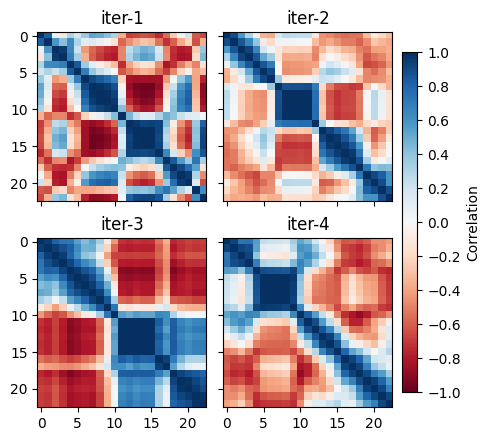

In [4]:
fig, axs = plt.subplots(2,2, figsize=(5,5), sharex=True, sharey=True)
axs = axs.reshape([-1])
axs[0].set_xticks(np.arange(0,25,5))
axs[0].set_yticks(np.arange(0,25,5))

for i in range(num_itr):
    axs[i].set_title('iter-%d'%(i+1))
    axs[i].set_box_aspect(1)
    im = axs[i].imshow(corl_data[i,:], cmap='RdBu', vmin=-1.0, vmax=1.0)

# Create a common colorbar
cbar_ax = fig.add_axes([0.81, 0.15, 0.03, 0.68])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(-1,1.2,0.2))
#cbar.set_ticklabels(np.arange(4))
cbar.set_label('Correlation')
 
#fig.tight_layout()
fig.subplots_adjust(hspace=0.15, left=0.08, wspace=0.1, right=0.79)
plt.savefig('correlation.pdf', format='pdf')

In [6]:
# load colvar data 

# initialize 
zeta_data = np.empty([sim_time, num_itr])
ld1_data = np.empty([sim_time, num_itr])
rbias_data = np.empty([sim_time, num_itr])
ld1_fes_data = []

for i in range(num_itr):
    path = "itr_%d"%(i+1)
    zeta_data[:,i] = np.loadtxt(path+"/zeta.txt")
    ld1_data[:,i], rbias_data[:,i] = np.loadtxt(path+"/COLVAR", usecols=(1,3), unpack=True)
    ld1_fes = np.loadtxt(path+"/fe_vs_ld1.txt", usecols=(0,1))
    ld1_fes_data.append(ld1_fes)
    
wgts_data = np.exp(rbias_data/kt)

# load zeta data from 4.5us long unbiased MD simulation
zeta_ref = []
path_to_ref = "/scratch/projects/hockygroup/ss12902/iterative_lda/aib9_5us_cmd_run/"
files = ["zeta_1500ns.txt", "zeta_3000ns.txt", "zeta_4500ns.txt"] 
for i in range(3):
    if i == 0:
        x = np.loadtxt(path_to_ref+files[i], usecols=1)
    else:
        x = np.loadtxt(path_to_ref+files[i], usecols=1, skiprows=2)
    zeta_ref.append(x)
zeta_ref = np.concatenate(zeta_ref, axis=0)
print(zeta_ref.shape)

(4500001,)


### MT figure : Aib$_9$ : $\zeta$ vs. Time

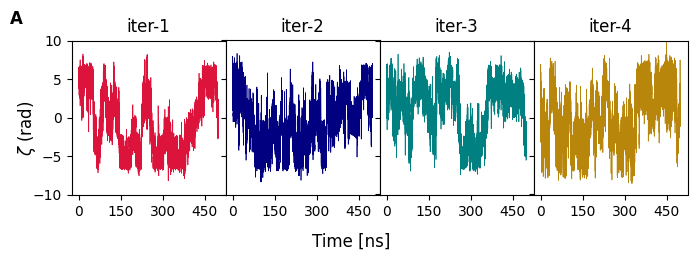

In [7]:
# make the zeta vs. time plot
colors = ['crimson', 'navy', 'teal', 'darkgoldenrod']
fig, axs = plt.subplots(1, 4, figsize=(7,2.5), sharex=True, sharey=True)
axs = axs.reshape([-1])

# 1st row 
axs[0].set_xticks(np.arange(0,600, 150))
axs[0].set_yticks(np.arange(-10, 15, 5))
axs[0].set_ylim(-10,10)
axs[0].text(-0.40, 1.2, st.ascii_uppercase[0], fontweight='bold', transform=axs[0].transAxes, fontsize=12, va='top')

for i in range(num_itr):
    axs[i].set_box_aspect(1)
    axs[i].set_title("iter-%d"%(i+1))
    axs[i].plot(time, zeta_data[:,i], color=colors[i], lw=0.5, alpha=1)
    
fig.supxlabel("Time [ns]")
fig.supylabel("$\zeta$ (rad)")
fig.subplots_adjust(wspace=0.0, bottom=0.1, right=0.98, left=0.10, top=0.98)

# save
plt.savefig("zeta_vs_time.pdf", format="pdf")

### MT figure : Aib$_9$ : FES vs. $\zeta$ 

/state/partition1/job-58677204/ipykernel_2624118/893621960.py:13: RuntimeWarning: divide by zero encountered in log
  fe = -kt*np.log(hist)


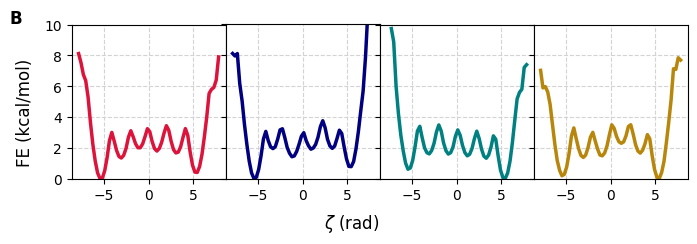

In [8]:
fig, axs = plt.subplots(1, num_itr, figsize=(7,2.5), sharex=True, sharey=True)

fig.supxlabel("$\zeta$ (rad)")
fig.supylabel("FE (kcal/mol)")

axs[0].set_xticks([-5,0,5])
axs[0].set_ylim(0,10)
axs[0].text(-0.4, 1.1, st.ascii_uppercase[1], transform=axs[0].transAxes, fontweight='bold', fontsize=12, va='top')

for i in range(num_itr):
    hist, edges = np.histogram(zeta_data[:,i], range=[-8,8], bins=60, density=True, weights=wgts_data[:,i])
    bins = (edges[1:]+edges[:-1])/2
    fe = -kt*np.log(hist)
    fe -= fe.min()
    
    axs[i].set_box_aspect(1)
    axs[i].grid(axis='both', which='major', linestyle='--', color='lightgrey')
    axs[i].plot(bins, fe, color=colors[i], label="iter-%d"%(i+1), lw=2.5, alpha=1)

fig.subplots_adjust(wspace=0.0, bottom=0.1, right=0.98, left=0.10, top=0.98)

# save
plt.savefig("fe_vs_zeta.pdf", format="pdf")

### SI figure : Aib$_9$ : FE convergence vs. $\zeta$

/state/partition1/job-58677204/ipykernel_2624118/844191326.py:19: RuntimeWarning: divide by zero encountered in log
  fe = -kt*np.log(hist)


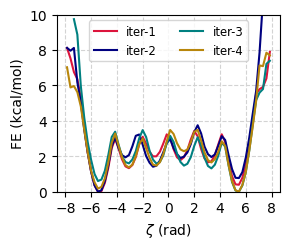

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(3,2.6))

axs.set_xlabel("$\zeta$ (rad)")
axs.set_ylabel("FE (kcal/mol)")
axs.set_xticks(np.arange(-8,10,2))

"""
hist_ref, edges = np.histogram(zeta_ref, range=[-8,8], bins=60, density=True)
bins = (edges[1:]+edges[:-1])/2.0
fe_ref = -kt*np.log(hist_ref)
fe_ref -= fe_ref.min()
axs.plot(bins, fe_ref, ls="--", color="grey", label="4.5us MD", lw=1.0)

"""
axs.set_ylim(0,10)
axs.grid(axis='both', which='major', linestyle='--', color='lightgrey')
for i in range(num_itr):
    hist = np.histogram(zeta_data[:,i], range=[-8,8], bins=60, density=True, weights=wgts_data[:,i])[0]
    fe = -kt*np.log(hist)
    fe -= fe.min()
    axs.plot(bins, fe, color=colors[i], label="iter-%d"%(i+1), lw=1.5)
axs.legend(fontsize="small", ncol=2)

fig.tight_layout()

# save 
plt.savefig("fe_vs_zeta_convg.pdf", format="pdf")

### SI figure : Aib$_9$ : LDA vs. Time 

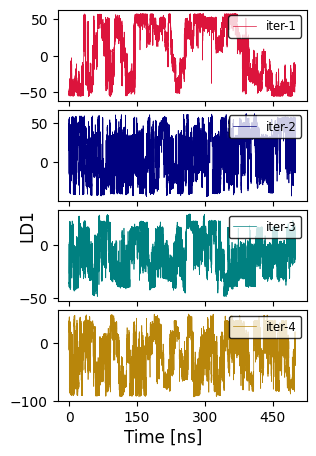

In [30]:
# make the ld1 vs. time plot
fig, axs = plt.subplots(4, 1, figsize=(3,4.5), sharex=True)
axs = axs.reshape([-1])

axs[0].set_xticks(np.arange(0,600, 150))
#axs[3].set_xlabel('Time [ns]')
for i in range(num_itr):
    #axs[i].set_title("iter-%d"%(i+1))
    
    #if i ==0 or i == 2:
        #axs[i].set_box_aspect(1)
    axs[i].plot(time, ld1_data[:,i], color=colors[i], lw=0.5, alpha=1, label='iter-%d'%(i+1))
    axs[i].legend(loc='upper right', fontsize='small', edgecolor='k')

        
    #else:
    #    axs[i].set_yticks([])
    #    inv_ax = axs[i].twinx()
    #    inv_ax.set_box_aspect(1)
    #    inv_ax.plot(time, ld1_data[:,i], color=colors[i], lw=0.5, alpha=1)
    
fig.supxlabel("Time [ns]")
fig.supylabel("LD1")
fig.subplots_adjust(hspace= 0.1, top=0.98, right=0.98, left=0.15)
#fig.tight_layout()

# save
plt.savefig("new_aib9_ld1_vs_time.pdf", format="pdf")

### SI figure : Aib$_9$ : FES vs. LD1

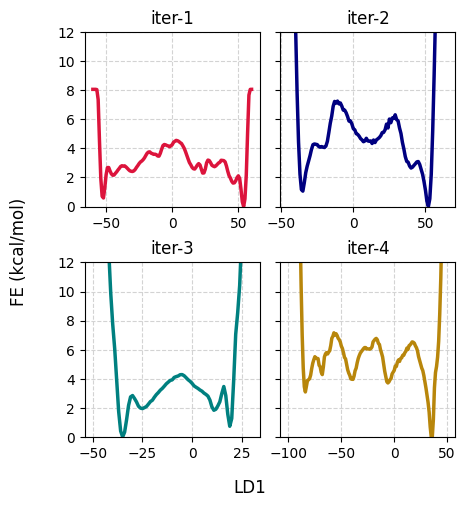

In [8]:
# make the FE vs. LD1 plot
fig, axs = plt.subplots(2, 2, figsize=(5,5), sharey=True)
axs = axs.reshape([-1])

axs[0].set_ylim(0,12)


for i in range(num_itr):
    axs[i].set_box_aspect(1)
    axs[i].set_title("iter-%d"%(i+1))
    axs[i].grid(axis='both', which='major', linestyle="--", color='lightgrey')
    axs[i].plot(ld1_fes_data[i][:,0], ld1_fes_data[i][:,1], color=colors[i], lw=2.5, alpha=1.0)
    
fig.supylabel("FE (kcal/mol)")
fig.supxlabel("LD1")
fig.subplots_adjust(wspace=-0.2, hspace= 0.32, bottom=0.13, right=0.98, left=0.10, top=0.94)
#fig.tight_layout()

# save
plt.savefig("fes_vs_ld1.pdf", format="pdf")

In [9]:
def plot_log_likelihood_with_dd(axis,cluster_array,train_log_lik,valid_log_lik,fontsize=16,xlabel=True,ylabel1=True,ylabel2=True, legend=True):
    """
    Plot log likelihood as a function of number of clusters for both training and cross validation.  These will be computed as the average over provided training sets.  Also compute and plot the second derivative of the training set data.
    Inputs:
        axis                    (required)  : matplotlib axis object
        cluster_array           (required)  : (n_clusters) int numpy array of number of clusters (x-values for this plot)
        train_log_lik           (required)  : (n_clusters, n_training_sets) float numpy array of log likelihood for training sets
        valid_log_lik           (required)  : (n_clusters, n_training_sets) float numpy array of log likelihood for CV sets
        fontsize                (optional)  : int defining fontsize to be used in the ploat, default is 16
        xlabel                  (optional)  : boolean defining whether or not to put an xlabel, default is True
        ylabel1                 (optional)  : boolean defining whether or not to put a left ylabel, default is True
        ylabel2                 (optional)  : boolean defining whether or not to put a right ylabel, default is True
        legend                  (optional)  : boolean defining whether or not to put a legend
    """
    colors = ["red", "blue", "black"]
    # Training Data
    train_mean = np.mean(train_log_lik,axis=1)
    train_std = np.std(train_log_lik,axis=1)
    axis.errorbar(cluster_array,train_mean,train_std,fmt='-o',lw=1,capsize=1,c=colors[0],label="Train")
    # Validation
    valid_mean = np.mean(valid_log_lik,axis=1)
    valid_std = np.std(valid_log_lik,axis=1)
    axis.errorbar(cluster_array,valid_mean,valid_std,fmt='--x',lw=1,capsize=1,c=colors[1],label="Cv")
    # Second derivative
    ax2 = axis.twinx()
    ax2.set_box_aspect(1)
    n_samples = train_log_lik.shape[1]
    n_clusters = train_log_lik.shape[0]
    dd = np.empty(train_log_lik.shape)
    for sample in range(n_samples):
        dd[:,sample] = np.gradient(np.gradient(train_log_lik[:,sample]))
    dd_mean = np.mean(dd,axis=1)
    dd_std = np.std(dd,axis=1)
    ax2.errorbar(cluster_array,dd_mean,dd_std,fmt='-^',lw=1,capsize=1,alpha=0.75,c=colors[2])
    #
    axis.grid(which='major', axis='both', color='#808080', linestyle='--')
    if ylabel1==True:
        axis.set_ylabel("LL per Frame",fontsize=fontsize)
    if ylabel2==True:
        ax2.set_ylabel("2$^{nd}$ derivative",fontsize=fontsize,color=colors[2])
    if xlabel==True:
        axis.set_xticks(cluster_array)
        axis.set_xlabel("Number of Clusters",fontsize=fontsize)
    ax2.tick_params(axis='both',labelsize=fontsize,labelcolor=colors[2])
    axis.tick_params(axis='both',labelsize=fontsize)
    if legend==True:
        axis.legend(fontsize="small", loc="lower right")

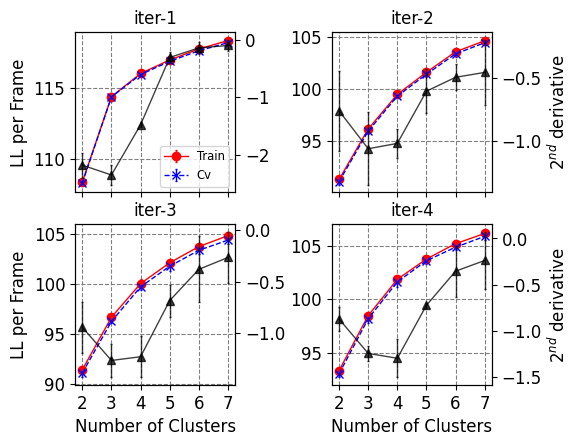

In [10]:
cluster_array = np.arange(2,8)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(6,4.7))
axs = axs.reshape([-1])

for i in range(num_itr):
    axs[i].set_box_aspect(1)
    axs[i].set_title("iter-%d"%(i+1))
    path = "itr_%d"%(i+1)
    train = np.loadtxt(path+"/train.dat")[:,1:]
    cv = np.loadtxt(path+"/cv.dat")[:,1:]
    if i == 0 :
        plot_log_likelihood_with_dd(axs[i], cluster_array, train, cv, fontsize=12, ylabel1=True, ylabel2=False, xlabel=False, legend=True)
    elif i == 1:
        plot_log_likelihood_with_dd(axs[i], cluster_array, train, cv, fontsize=12, ylabel1=False, ylabel2=True, xlabel=False, legend=False)
    elif i == 2:
        plot_log_likelihood_with_dd(axs[i], cluster_array, train, cv, fontsize=12, ylabel1=True, ylabel2=False, xlabel=True, legend=False)
    elif i == 3:
        plot_log_likelihood_with_dd(axs[i], cluster_array, train, cv, fontsize=12, ylabel1=False, ylabel2=True, xlabel=True, legend=False)

fig.subplots_adjust(wspace=0.15, left=0.1, right=0.9, bottom=0.15, top=0.9)
#fig.tight_layout()

# save 
plt.savefig("train_curve_vertical_with_dd.pdf", format="pdf")

### SI figure : Aib$_9$ : LDA coefficients

In [11]:
# load all the LD1 coefficients data 
ld1_coeff_data = np.empty([69, num_itr])

for i in range(num_itr):
    path = "itr_%d"%(i+1)
    if i == 0:
        ld1_coeff_data[:,i] = np.loadtxt(path+"/ld1_scalings.txt")
    elif i == 3:
        ld1_coeff_data[:,i] = np.loadtxt(path+"/ld1_4states_scalings.txt")
    else:
        ld1_coeff_data[:,i] = np.loadtxt(path+"/ld1_3states_scalings.txt")

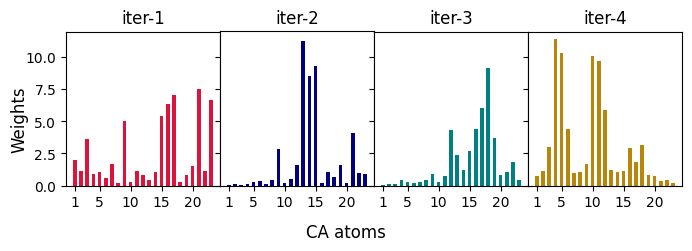

In [12]:
fig, axs = plt.subplots(1, num_itr, figsize=(7,2.5), sharex=True, sharey=True)
fig.supxlabel("CA atoms")
fig.supylabel("Weights")

for i in range(num_itr):
    vals = np.sqrt(np.sum(np.square(ld1_coeff_data[:,i].reshape(23,3)), axis=1))
    axs[i].set_box_aspect(1)
    axs[i].set_title("iter-%d"%(i+1))
    axs[i].set_xticks([1,5,10,15,20])
    axs[i].bar(np.arange(23)+1, vals, width=0.6, color=colors[i], align='center')
    
#fig.subplots_adjust(wspace=0, bottom=0.21, right=0.98, left=0.08, top=0.88)
fig.subplots_adjust(wspace=0.0, bottom=0.1, right=0.98, left=0.10, top=0.98)

# save
plt.savefig("lda_coeffs_aib9.pdf", format="pdf")

### compute the refernce (fully converged) FE profile along zeta from longest metad run

In [13]:
#z = np.loadtxt('itr_4/concat_zeta_3us.txt')
#t, b = np.loadtxt('itr_4/COLVAR_3us', usecols=(0,3), unpack=True)

z = np.loadtxt('itr_4/concat_zeta_4.5us.txt')
t, b = np.loadtxt('itr_4/COLVAR_4.5us', usecols=(0,3), unpack=True)

t *= 1e-3 # in ns 
print(z.shape, b.shape)

wgts = np.exp(b/kt)

h, e = np.histogram(z, bins=60, range=[-8,8], density=True, weights=wgts)
g = (e[1:]+e[:-1])/2
f =-kt*np.log(h)
f -= f.min()

(4500002,) (4500002,)


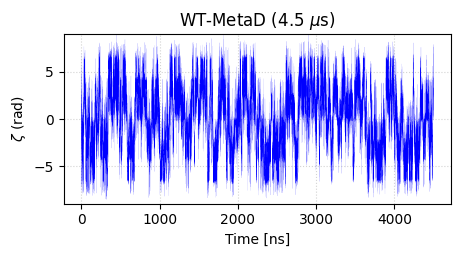

In [14]:
plt.figure(figsize=(5,2.2))
plt.ylabel('$\zeta$ (rad)')
plt.xlabel('Time [ns]')
plt.ylim(-9,9)
plt.grid(axis='both', which='major', linestyle=':', color='lightgrey')
plt.title("WT-MetaD (4.5 $\mu$s)")
plt.plot(t, z, color='blue', lw=0.05, alpha=1)

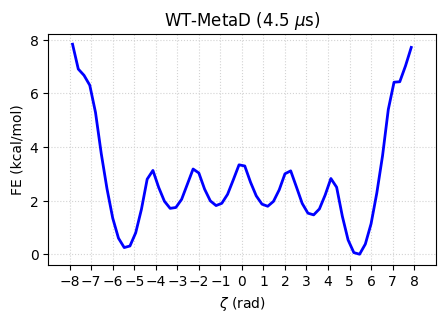

In [15]:
plt.figure(figsize=(5,3))
plt.xticks(np.arange(-8,9,1))
plt.xlim(-9,9)
plt.ylabel('FE (kcal/mol)')
plt.xlabel('$\zeta$ (rad)')
plt.grid(axis='both', which='major', linestyle=':', color='lightgrey')
plt.title("WT-MetaD (4.5 $\mu$s)")
plt.plot(g, f, color='b', lw=2)

In [37]:
## load dihedral data from 4.5us long sim

phi_vals_list = np.load('itr_4/phi_vals_list.npy', allow_pickle=True)[:,1:6] # only using dih-3, ..., dih-7
print(phi_vals_list.shape)

(4500002, 5)


In [38]:
right_helix_range = [-6.5, -4.5]
imdt_1_range = [-4.2, -2.2]

right_helix_indx = [x[0] for x in np.argwhere((z >= right_helix_range[0]) & (z < right_helix_range[1]))]
imdt_1_indx = [x[0] for x in np.argwhere((z >= imdt_1_range[0]) & (z < imdt_1_range[1]))]

right_helix_phi_data = phi_vals_list[right_helix_indx]
imdt_1_phi_data = phi_vals_list[imdt_1_indx]


right_helix_wgts = wgts[right_helix_indx]
imdt_1_wgts = wgts[imdt_1_indx]

print(right_helix_phi_data.shape, imdt_1_phi_data.shape)
print(right_helix_wgts.shape, imdt_1_wgts.shape)

(497089, 5) (855701, 5)
(497089,) (855701,)


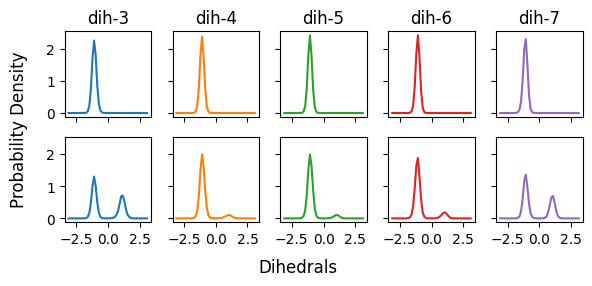

In [64]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(6, 3))
comb_phi_data  = [right_helix_phi_data, imdt_1_phi_data]
comb_wgts_data = [right_helix_wgts, imdt_1_wgts]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for i in range(2):
    X = comb_phi_data[i]
    W = comb_wgts_data[i]
    
    # loop over dihedrals
    for j in range(5):
        Xj = X[:,j]
        Hj, edges = np.histogram(Xj, range=[-3.14,3.14], bins=50, weights=W, density=True)
        bins = (edges[1:]+edges[:-1])/2
        
        #axs[i,j].set_box_aspect(1)
        if i ==0:
            axs[i,j].set_title('dih-%d'%(j+3))
        axs[i,j].plot(bins, Hj, color=colors[j])

fig.supxlabel('Dihedrals', y=0.06)
fig.supylabel('Probability Density', y=0.55)
fig.tight_layout()
#fig.subplots_adjust(wspace=0.1, hspace=0)

plt.savefig('aib9_dih_histo.pdf', format='pdf')

### compute the ref FE vs. LD1 at each iteration computed using longest 4.5$\mu$s simulation 

In [23]:
nbins_ = [120, 110, 80, 150]
ranges_ = [[-60,60], [-45,65], [-50,30], [-100,50]]

In [24]:
# load from the main sim data
t, l, b = np.loadtxt('itr_4/COLVAR_4.5us', usecols=(0,1,3), unpack=True)   # time, ld1, bias 

store_data_ = []
# load other LD1 values computed from this sim
for i in range(3):
    x = np.loadtxt('itr_%d/LD1_VALS'%(i+1), usecols=1)
    #print(x.shape)
    store_data_.append(x)

store_data_.append(l)
store_data_ = np.array(store_data_)
print(store_data_.shape)

# now get the ref FE profiles along LD1
ref_fes_data_ = []
for i in range(4):
    #h, bins = np.histogram(store_data_[i,:], bins=120, density=True, weights=np.exp(b/kt))
    h, bins = np.histogram(store_data_[i,:], bins=nbins_[i], range=ranges_[i], density=True, weights=np.exp(b/kt))
    g = (bins[1:] + bins[:-1])/2
    f = -kt*np.log(h)
    f -= f.min()
    xy = np.array([g, f])
    print(xy.shape)
    ref_fes_data_.append(xy)
    
#ref_fes_data_ = np.array(ref_fes_data_)
#print(ref_fes_data_.shape)

(4, 4500002)
(2, 120)
(2, 110)


/state/partition1/job-60664323/ipykernel_3638795/3348889921.py:21: RuntimeWarning: divide by zero encountered in log
  f = -kt*np.log(h)


(2, 80)
(2, 150)


### load data from extended 1.5 $\mu$s simulations 

In [6]:
sim_time = 1500001  # in ps (fixed for each simulation)
time = np.arange(sim_time)*1e-3 # in ns

In [7]:
# load colvar data 

# initialize 
zeta_data_long = np.empty([sim_time, num_itr])
ld1_data_long = np.empty([sim_time, num_itr])
rbias_data_long = np.empty([sim_time, num_itr])
ld1_fes_data_long = []

for i in range(num_itr):
    path = "itr_%d"%(i+1)
    zeta_data_long[:,i] = np.loadtxt(path+"/concat_zeta.txt")
    ld1_data_long[:,i], rbias_data_long[:,i] = np.loadtxt(path+"/COLVAR_1.5us", usecols=(1,3), unpack=True)
    ld1_fes_long = np.loadtxt(path+"/fe_vs_ld1_1.5us.txt", usecols=(0,1))
    ld1_fes_data_long.append(ld1_fes_long)
    
wgts_data_long = np.exp(rbias_data_long/kt)

In [8]:
print(zeta_data_long.shape)
print(rbias_data_long.shape)
print(ld1_data_long.shape)

(1500001, 4)
(1500001, 4)
(1500001, 4)


### compare with ref fes along LD1 

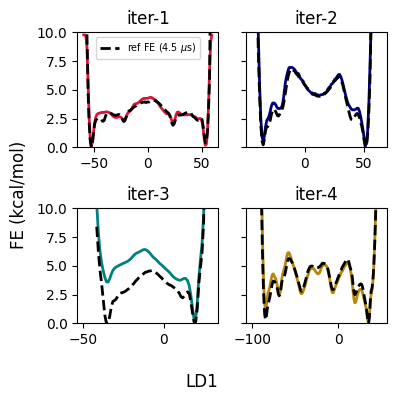

In [33]:
# make the FE vs. LD1 plot
fig, axs = plt.subplots(2, 2, figsize=(4,4), sharey=True)
axs = axs.reshape([-1])

axs[0].set_ylim(0,10)
colors = ['crimson', 'navy', 'teal', 'darkgoldenrod']

for i in range(num_itr):
    #axs[i].set_box_aspect(1)
    axs[i].set_title("iter-%d"%(i+1))
    #axs[i].grid(axis='both', which='major', linestyle="--", color='lightgrey')
    
    #axs[i].plot(ld1_fes_data_long[i][:,0], ld1_fes_data_long[i][:,1], color=colors[i], lw=2, alpha=1.0)
    
    xi = ld1_fes_data_long[i][:,0]
    yi = ld1_fes_data_long[i][:,1]
    
    xi_ = (xi[1:]+xi[:-1])/2
    yi_ = (yi[1:]+yi[:-1])/2
    
    axs[i].plot(xi_, yi_, color=colors[i], lw=2, alpha=1.0)
    
    #axs[i].plot(ref_fes_data_[i,0,:], ref_fes_data_[i,1,:], 'k--', lw=2, label='ref FE (4.5 $\mu$s)')
    axs[i].plot(ref_fes_data_[i][0,:], ref_fes_data_[i][1,:], 'k--', lw=2, label='ref FE (4.5 $\mu$s)')
    if i ==0:
        axs[i].legend(fontsize='x-small', loc='upper center')
    
    
fig.supylabel("FE (kcal/mol)")
fig.supxlabel("LD1")
#fig.subplots_adjust(hspace= 0.2, bottom=0.08, right=0.98, top=0.98, left=0.1)
fig.tight_layout()

# save
#plt.savefig("", format="pdf")

### plot fe vs. ld1 (sum_hills) @time =250,500,750,1000,1250,1500ns from individual iteration runs

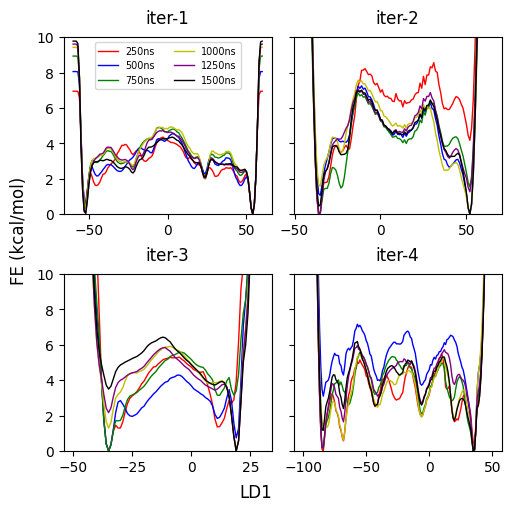

In [34]:
# make the FE vs. LD1 plot
fig, axs = plt.subplots(2, 2, figsize=(5,5), sharey=True, constrained_layout=True)
axs = axs.reshape([-1])

axs[0].set_ylim(0,10)

clrs = ['r', 'b', 'g', 'y', 'purple', 'k']
for i in range(num_itr):
    axs[i].set_title(f"iter-{i+1}", pad=10)  # Added pad to title
        
    for j in range(6):   
        x, y = np.loadtxt(f'itr_{i+1}/f_{(j+1)*250}.txt', usecols=(0,1), unpack=True)
        axs[i].plot(x, y, lw=1, alpha=1, label=f'{(j+1)*250}ns', color=clrs[j])
        
    if i == 0:
        axs[i].legend(fontsize='x-small', loc='upper center', ncol=2)

fig.supylabel("FE (kcal/mol)", y=0.55)  # Adjusted vertical position
fig.supxlabel("LD1")

# plt.savefig("output.pdf", bbox_inches='tight')  # If saving
plt.show()

### load fes every 100ns for each iteration upto 1.5 $\mu$s obtained by summing hills

In [35]:
print(nbins_, ranges_)

[120, 110, 80, 150] [[-60, 60], [-45, 65], [-50, 30], [-100, 50]]


In [36]:
all_itr_fes_every_100ns_ = []
num_strd_ = 15

for i in  range(num_itr):
    Xi = np.empty([num_strd_, nbins_[i]])
    
    for j in range(num_strd_):
        xj = np.loadtxt('itr_%d/fes_%d.dat'%(i+1,j), usecols=1)
        Xi[j,:] = (xj[1:]+xj[:-1])/2
    
    print(Xi.shape)
    all_itr_fes_every_100ns_.append(Xi)

(15, 120)
(15, 110)
(15, 80)
(15, 150)


### plot this please

In [27]:
bold_colors = [
    '#2F4F4F',  # dark slate gray (bold neutral)
    '#8B0000',  # dark red
    '#00008B',  # dark blue
    '#006400',  # dark green
    '#FF4500',  # orange-red
    '#9400D3',  # dark violet
    '#FFD700',  # gold
    '#00CED1',  # dark turquoise
    '#FF69B4',  # hot pink
    '#4B0082',  # indigo
    '#FF6347',  # tomato
    '#7CFC00',  # lawn green
    '#4682B4',  # steel blue
    '#D2691E',  # chocolate
    '#8A2BE2',  # blue violet
]

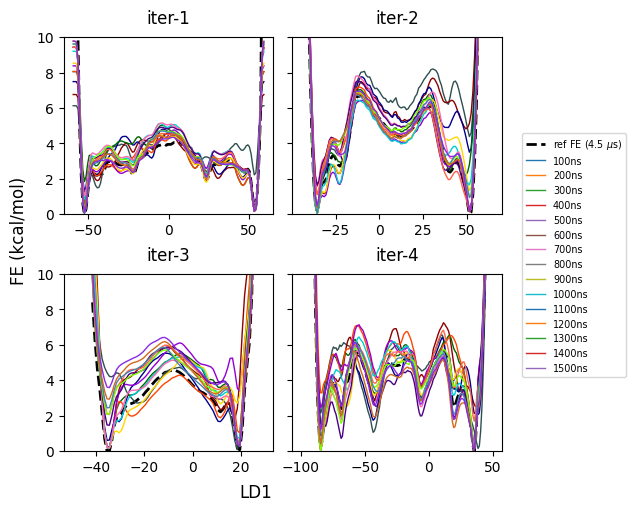

In [71]:
# make the FE vs. LD1 plot
fig, axs = plt.subplots(2, 2, figsize=(5,5), sharey=True, constrained_layout=True)
axs = axs.reshape([-1])

axs[0].set_ylim(0,10)

# Create lists to store the plot elements for the legend
legend_elements = []

# First collect all the lines we want in the legend
ref_line = axs[0].plot([], [], 'k--', lw=2, label='ref FE (4.5 $\mu$s)')[0]
legend_elements.append(ref_line)

for j in range(num_strd_):
    line = axs[0].plot([], [], lw=1, alpha=1, label=f'{(j+1)*100}ns')[0]
    legend_elements.append(line)

# Now make the actual plots
for i in range(num_itr):
    axs[i].set_title(f"iter-{i+1}", pad=10)
    axs[i].plot(ref_fes_data_[i][0,:], ref_fes_data_[i][1,:], 'k--', lw=2)
    
    for j in range(num_strd_):   
        axs[i].plot(ref_fes_data_[i][0,:], all_itr_fes_every_100ns_[i][j,:], lw=1, alpha=1, color=bold_colors[j])

# Add the common legend outside the plots on the right
fig.legend(handles=legend_elements, 
           loc='center right', 
           bbox_to_anchor=(1.25, 0.5),  # Adjust these values as needed
           fontsize='x-small')

fig.supylabel("FE (kcal/mol)", y=0.55)
fig.supxlabel("LD1")

#fig.tight_layout()

plt.show()

### let's calculate error w.r.t final fes obtained from long run 4.5 $\mu$s in each case by reweighting

In [102]:
rmse_err_ = np.empty([num_itr, num_strd_])
intvl_ = 100000  # 100 ns
ener_cut_off = 7.5 # kcal/mol unit 

for i in range(num_itr):
    RFi = ref_fes_data_[i][1,:]    # ref free energy profile    
    for j in range(num_strd_):
        Fj = all_itr_fes_every_100ns_[i][j,:]
        
        # calcute MAE
        #rmse_err_[i,j] = np.mean(np.abs(Fj-RFi)[RFi<ener_cut_off])
        
        # calculate mean relative error
        rmse_err_[i,j] = np.mean((np.abs(Fj-RFi)/RFi)[RFi<ener_cut_off])

/state/partition1/job-60664323/ipykernel_3638795/864088307.py:14: RuntimeWarning: divide by zero encountered in divide
  rmse_err_[i,j] = np.mean((np.abs(Fj-RFi)/RFi)[RFi<ener_cut_off])
/state/partition1/job-60664323/ipykernel_3638795/864088307.py:14: RuntimeWarning: invalid value encountered in divide
  rmse_err_[i,j] = np.mean((np.abs(Fj-RFi)/RFi)[RFi<ener_cut_off])


In [114]:
rmse_err_ = np.empty([num_itr, num_strd_])
intvl_ = 100000  # 100 ns
ener_cut_off = 7.5  # kcal/mol unit 

eps = 1e-5

for i in range(num_itr):
    RFi = ref_fes_data_[i][1,:]    # ref fes profiles
    for j in range(num_strd_):
        Fj = all_itr_fes_every_100ns_[i][j,:]
        
        # Only consider points where RFi < cutoff AND RFi != 0
        mask = (RFi < ener_cut_off) & (RFi > eps)
        
        if np.any(mask): 
            relative_errors = np.abs(Fj[mask] - RFi[mask])/(RFi[mask]+eps)
            rmse_err_[i,j] = np.mean(relative_errors)
        else:
            rmse_err_[i,j] = np.nan 

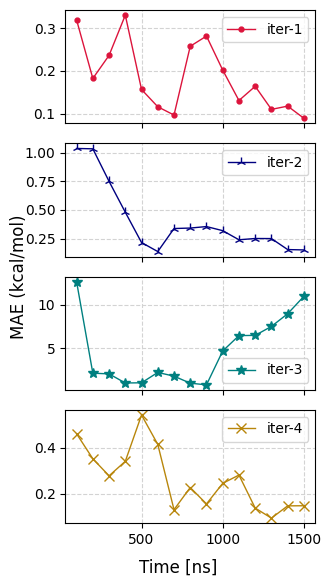

In [115]:
fig, axs = plt.subplots(4,1, figsize=(3.5,6), sharex=True, sharey=False)
axs = axs.reshape([-1])

colors = ['crimson', 'navy', 'teal', 'darkgoldenrod']
marker_styles = ['.', '2', '*', 'x']

fig.supxlabel('Time [ns]', y=0.03, x=0.55)
#fig.supylabel('RMSE (kcal/mol)', y=0.53, x=0.07)
fig.supylabel('MAE (kcal/mol)', y=0.53, x=0.07)

for i in range(4):
    #axs[i].set_ylim(0,1.75)
    #axs[i].set_yticks([0, 0.5, 1, 1.5])
    axs[i].grid(axis='both', which='major', linestyle='--', color='lightgrey')
    axs[i].plot(np.arange(1, rmse_err_.shape[1]+1)*intvl_*1e-3, rmse_err_[i,:], marker=marker_styles[i], ms=7, linestyle='-', lw=1, color=colors[i], label='iter-%d'%(i+1))
    axs[i].legend()

fig.tight_layout()

### make the error plots 

In [107]:
print("nbins_ =", nbins_)
print(b.shape)
print(store_data_.shape)

nbins_ = [120, 110, 80, 150]
(4500002,)
(4, 4500002)


In [108]:
[a.shape for a in ref_fes_data_]

[(2, 120), (2, 110), (2, 80), (2, 150)]

In [109]:
intvl_ = 100000  # 100 ns
ener_cut_off = 7.50
error_data_ = np.empty([4, int(store_data_.shape[1]/intvl_)])

# loop over iterations
for i in range(4):
    
    Xi = store_data_[i,:]          # ld1 data 
    RFi = ref_fes_data_[i][1,:]    # ref free energy profile
    Ai = np.where(RFi <= ener_cut_off, RFi, 0)   # considering regions only below cut-off energy
    
    # increment 100ns in every loop
    for j in range(int(Xi.shape[0]/intvl_)):
        
        Xj = Xi[:((j+1)*intvl_)+1:]
        Wj = np.exp(b/kt)[:((j+1)*intvl_+1):]
        
        # cal free energy
        Hj, _ = np.histogram(Xj, bins=nbins_[i], density=True, weights=Wj)
        Fj = -kt*np.log(Hj)
        Fj -= Fj.min()
        
        # current fe
        Bj = np.where(RFi <= ener_cut_off, Fj, 0)
        
        # rmse btw current and ref fes
        error_data_[i,j] = np.std(Ai-Bj)

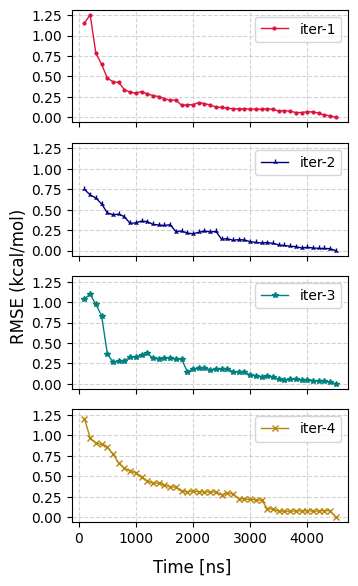

In [110]:
fig, axs = plt.subplots(4,1, figsize=(3.8,6), sharex=True, sharey=True)
axs = axs.reshape([-1])

colors = ['crimson', 'navy', 'teal', 'darkgoldenrod']
marker_styles = ['.', '2', '*', 'x']

fig.supxlabel('Time [ns]', y=0.03, x=0.55)
fig.supylabel('RMSE (kcal/mol)', y=0.53, x=0.07)

for i in range(4):
    axs[i].set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
    axs[i].grid(axis='both', which='major', linestyle='--', color='lightgrey')
    axs[i].plot(np.arange(1, error_data_.shape[1]+1)*intvl_*1e-3, error_data_[i,:], marker=marker_styles[i], ms=4, linestyle='-', lw=1, color=colors[i], label='iter-%d'%(i+1))
    axs[i].legend()

fig.tight_layout()

In [111]:
print(len(np.arange(1, error_data_.shape[1]+1)*intvl_*1e-3))

45


### SI figure : Aib$_9$ : $\zeta$ vs. time (1.5$\mu$s long simulations) 

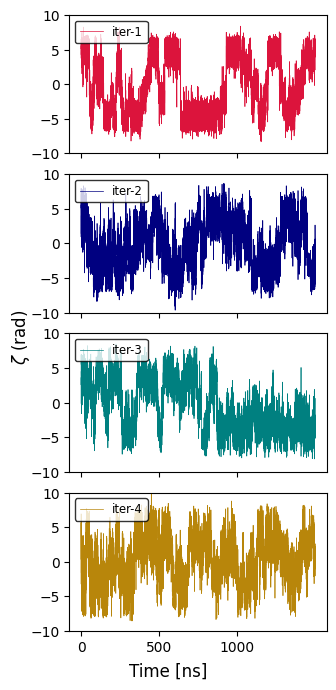

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(3.3,7), sharex=True, sharey=True)
axs = axs.reshape([-1])

colors = ['crimson', 'navy', 'teal', 'darkgoldenrod']

# 1st row 
axs[0].set_xticks(np.arange(0,1500, 500))
axs[0].set_yticks(np.arange(-10, 15, 5))
axs[0].set_ylim(-10,10)

for i in range(num_itr):
    #axs[i].set_box_aspect(1)
    #axs[i].set_title("iter-%d"%(i+1))
    axs[i].plot(time, zeta_data_long[:,i], color=colors[i], lw=0.5, alpha=1, label="iter-%d"%(i+1))
    axs[i].legend(fontsize='small', loc='upper left', edgecolor='k')
    
fig.supxlabel("Time [ns]")
fig.supylabel("$\zeta$ (rad)")
fig.subplots_adjust(wspace=0.0, hspace=0.15, bottom=0.08, right=0.98, left=0.20, top=0.96)

# save
plt.savefig("zeta_vs_time_1.5us.pdf", format="pdf")

### SI figure : Aib$_9$ : FES vs. $\zeta$ (1.5$\mu$s long simulations) 

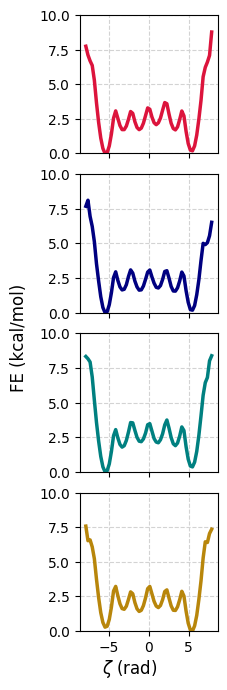

In [10]:
fig, axs = plt.subplots(num_itr, 1, figsize=(2.5,7), sharex=True, sharey=True)

fig.supxlabel("$\zeta$ (rad)")
fig.supylabel("FE (kcal/mol)")

axs[0].set_xticks([-5,0,5])
axs[0].set_ylim(0,10)

for i in range(num_itr):
    # histogram 
    hist, edges = np.histogram(zeta_data_long[:,i], range=[-8,8], bins=60, density=True, weights=wgts_data_long[:,i])
    bins = (edges[1:]+edges[:-1])/2
    fe = -kt*np.log(hist)
    fe -= fe.min()
    
    axs[i].set_box_aspect(1)
    axs[i].grid(axis='both', which='major', linestyle='--', color='lightgrey')
    axs[i].plot(bins, fe, color=colors[i], label="iter-%d"%(i+1), lw=2.5, alpha=1)

fig.subplots_adjust(wspace=0.0, hspace=0.15, bottom=0.08, right=1.0, left=0.15, top=0.96)

# save
plt.savefig("fe_vs_zeta_1.5us.pdf", format="pdf")

### convergence of FES along $\zeta$ from long simulations 

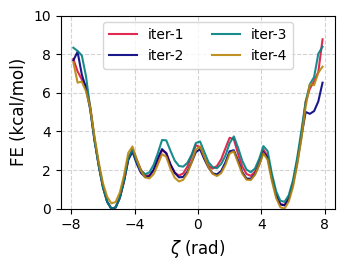

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(3.25,2.5), sharex=True, sharey=True)

ax.set_xlabel("$\zeta$ (rad)", fontsize=12)
ax.set_ylabel("FE (kcal/mol)", fontsize=12)
ax.set_xticks([-8,-4,0,4,8])
#ax.set_xticks([-5,0,5])
ax.set_ylim(0,10)
ax.grid(axis='both', which='major', linestyle='--', color='lightgrey')

for i in range(num_itr):
    # histogram 
    hist, edges = np.histogram(zeta_data_long[:,i], range=[-8,8], bins=60, density=True, weights=wgts_data_long[:,i])
    bins = (edges[1:]+edges[:-1])/2
    fe = -kt*np.log(hist)
    fe -= fe.min()
    ax.plot(bins, fe, color=colors[i], label="iter-%d"%(i+1), lw=1.5, alpha=0.9)

    ax.legend(ncol=2)
fig.tight_layout(pad=0)

# save
plt.savefig("fes_vs_zeta_convg_1.5us.pdf", format="pdf")

### plot FE vs. $\zeta$ every 100ns for each iteration and error calculation w.r.t reference FE

/state/partition1/job-60780300/ipykernel_35570/847288033.py:25: RuntimeWarning: divide by zero encountered in log
  fj = -kt*np.log(hj)


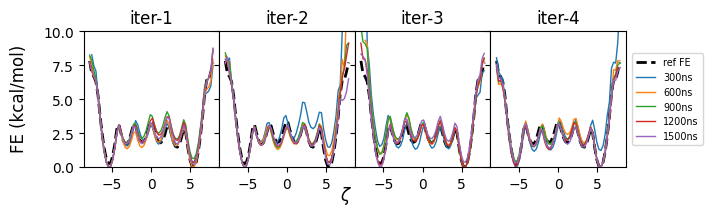

In [20]:
intvl_ = 100000  # 100ns 
num_strd_ = 15

error_data_ = np.empty([num_itr, num_strd_])
ener_cut_off_ = 7.50  # in kcal/mol unit

fig, axs = plt.subplots(1, 4, figsize=(7,2.2), sharex=True, sharey=True)
axs = axs.reshape([-1])

axs[0].set_ylim(0,10)
for i in range(num_itr):
    axs[i].set_box_aspect(1)
    axs[i].set_title('iter-%d'%(i+1))
    axs[i].plot(g, f, 'k--', lw=2, label='ref FE', alpha=1)
    
    Zi = zeta_data_long[:,i]
    Wi = wgts_data_long[:,i]
    
    for j in range(num_strd_):
        zj = Zi[:((j+1)*intvl_)+1:]
        wj = Wi[:((j+1)*intvl_)+1:]
        
        # cal fes
        hj, _ = np.histogram(zj, bins=60, range=[-8,8], density=True, weights=wj)
        fj = -kt*np.log(hj)
        fj -= fj.min()
        
        
        #error_data_[i,j] = np.mean(np.abs(fj-f)[ (fj < ener_cut_off_) & (f<ener_cut_off_)])
        error_data_[i,j] = np.mean(np.abs(fj-f)[fj < ener_cut_off_])
        
        if j % 3 == 2:
            axs[i].plot(g, fj, lw=1, alpha=1, label=f'{(j+1)*100}ns')
axs[0].legend(loc='center right', fontsize='x-small', bbox_to_anchor=[4.6,0.5])
fig.supxlabel('$\zeta$', y=0.01)
fig.supylabel('FE (kcal/mol)')
fig.subplots_adjust(wspace=0)
plt.savefig('zeta_fes_convg.pdf', format='pdf', bbox_inches='tight')

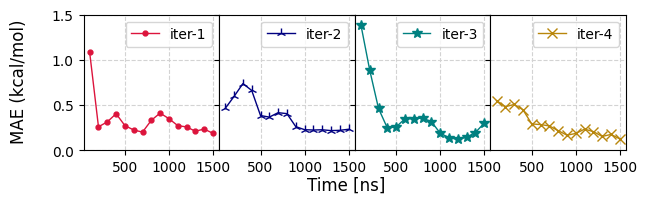

In [21]:
fig, axs = plt.subplots(1,4, figsize=(7,2.3), sharex=True, sharey=True)
axs = axs.reshape([-1])

colors = ['crimson', 'navy', 'teal', 'darkgoldenrod']
marker_styles = ['.', '2', '*', 'x']

for i in range(4):
    axs[i].set_box_aspect(1)
    axs[i].set_ylim(0,1.5)
    axs[i].set_yticks([0, 0.5, 1, 1.5])
    axs[i].grid(axis='both', which='major', linestyle='--', color='lightgrey')
    axs[i].plot((np.arange(1, num_strd_+1)*intvl_*1e-3), error_data_[i,:], marker=marker_styles[i], ms=7, linestyle='-', lw=1, color=colors[i], label='iter-%d'%(i+1))
    axs[i].legend()
    
fig.supxlabel('Time [ns]', y=0.01)
fig.supylabel('MAE (kcal/mol)')
fig.subplots_adjust(wspace=0)
plt.savefig('zeta_error_convg.pdf', format='pdf')

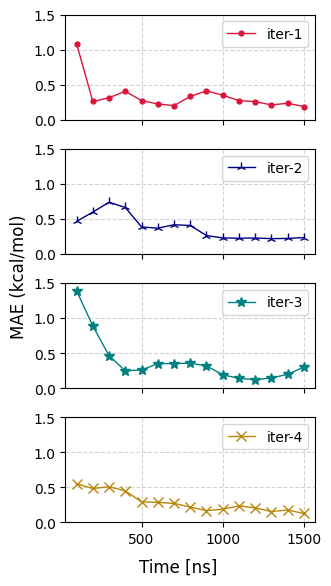

In [13]:
fig, axs = plt.subplots(4,1, figsize=(3.5,6), sharex=True, sharey=True)
axs = axs.reshape([-1])

colors = ['crimson', 'navy', 'teal', 'darkgoldenrod']
marker_styles = ['.', '2', '*', 'x']

fig.supxlabel('Time [ns]', y=0.03, x=0.55)
fig.supylabel('MAE (kcal/mol)', y=0.53, x=0.07)

for i in range(4):
    axs[i].set_ylim(0,1.5)
    axs[i].set_yticks([0, 0.5, 1, 1.5])
    axs[i].grid(axis='both', which='major', linestyle='--', color='lightgrey')
    axs[i].plot((np.arange(1, num_strd_+1)*intvl_*1e-3), error_data_[i,:], marker=marker_styles[i], ms=7, linestyle='-', lw=1, color=colors[i], label='iter-%d'%(i+1))
    axs[i].legend()

fig.tight_layout()

In [14]:
print(error_data_)

[[1.08299072 0.25967874 0.31357598 0.40422946 0.27285899 0.22421698
  0.20075573 0.33126366 0.41132584 0.34920636 0.27284166 0.25794719
  0.210827   0.23435133 0.18767202]
 [0.46395867 0.59591905 0.73719761 0.66154338 0.38408255 0.36671574
  0.4158362  0.40497025 0.26164755 0.227693   0.22386908 0.22670936
  0.21749631 0.22061919 0.23241719]
 [1.38655659 0.88614743 0.46196381 0.24671295 0.25735772 0.3488956
  0.34960605 0.35559939 0.31658023 0.18959526 0.13948201 0.11994995
  0.14395414 0.19628916 0.30061673]
 [0.54888416 0.48169409 0.5066227  0.44761184 0.29098394 0.28441807
  0.26904852 0.21664126 0.16658308 0.18598509 0.23395475 0.2058398
  0.15304894 0.17517997 0.12543949]]


In [15]:
print(zeta_data_long.shape, wgts_data_long.shape)

(1500001, 4) (1500001, 4)


### SI figure : Aib$_9$ : LDA vs. time (1.5 $\mu$s long simulations) 

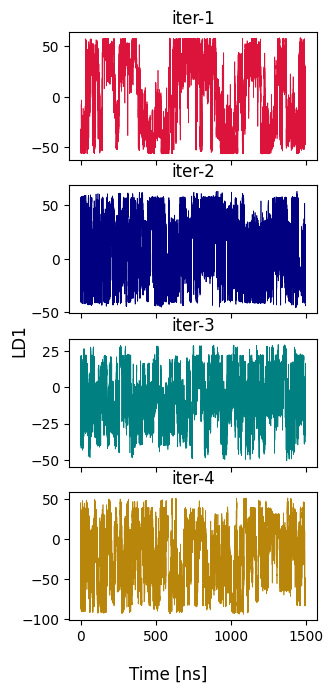

In [18]:
# make the ld1 vs. time plot
fig, axs = plt.subplots(4, 1, figsize=(3.3,7), sharex=True)
axs = axs.reshape([-1])

#axs[0].set_xticks(np.arange(0,600, 150))

for i in range(num_itr):
    axs[i].set_title("iter-%d"%(i+1))
    axs[i].plot(time, ld1_data_long[:,i], color=colors[i], lw=0.5, alpha=1)

fig.supxlabel("Time [ns]")
fig.supylabel("LD1")
fig.subplots_adjust(wspace=0.0, hspace= 0.2, bottom=0.1, right=0.95, left=0.20, top=0.94)
#ig.tight_layout()

# save
plt.savefig("ld1_vs_time_1.5us.pdf", format="pdf")

### SI figure : Aib$_9$ : FES vs. LD1 (1.5 $\mu$s long simulations)

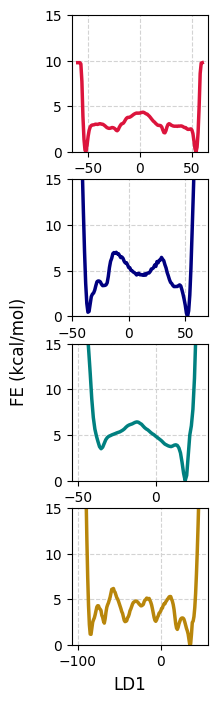

In [19]:
# make the FE vs. LD1 plot
fig, axs = plt.subplots(4, 1, figsize=(2.5,7), sharey=True)
axs = axs.reshape([-1])

axs[0].set_ylim(0,15)


for i in range(num_itr):
    axs[i].set_box_aspect(1)
    #axs[i].set_title("iter-%d"%(i+1))
    axs[i].grid(axis='both', which='major', linestyle="--", color='lightgrey')
    axs[i].plot(ld1_fes_data_long[i][:,0], ld1_fes_data_long[i][:,1], color=colors[i], lw=2.5, alpha=1.0)
    
fig.supylabel("FE (kcal/mol)")
fig.supxlabel("LD1")
fig.subplots_adjust(hspace= 0.2, bottom=0.08, right=0.98, top=0.98, left=0.1)
#fig.tight_layout()

# save
plt.savefig("fes_vs_ld1_1.5us.pdf", format="pdf")

### SI figure :  Aib$_9$ : Bhattacharyya Distance 

In [20]:
logb_dist_data = []
for i in range(3):
    x = np.loadtxt('itr_%d/logb-dist.txt'%(i+2))
    logb_dist_data.append(x)
print(logb_dist_data)

[array([[6.33119214, 0.733879  ],
       [1.15550474, 5.8542002 ],
       [2.46327672, 2.30562821]]), array([[ 6.65071679, -0.02188982],
       [ 2.33552179,  2.26294469],
       [ 1.38323648,  5.198488  ]]), array([[-0.93623784,  6.92198278],
       [ 2.09189178,  2.41459771],
       [ 7.0769303 , -3.37394573],
       [ 2.27252267,  2.41291336]])]


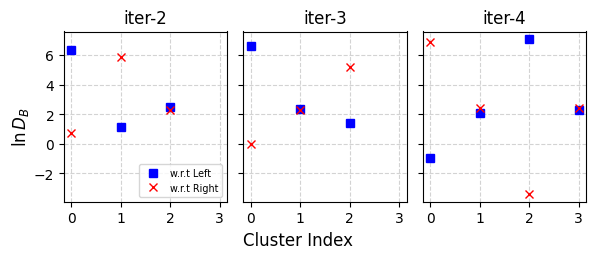

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(6,2.5), sharey=True, sharex=True)
fig.supxlabel('Cluster Index')
fig.supylabel('$\ln{D_B}$')

for i in range(3):
    #axs[i].set_aspect(1)
    axs[i].set_title('iter-%d'%(i+2))
    axs[i].grid(axis='both', which='major', linestyle='--', color='lightgrey')
    axs[i].set_xticks(np.arange(4))
    for j in range(logb_dist_data[i].shape[0]):
        if i ==0 and j ==0:
            axs[i].plot(j, logb_dist_data[i][j,0], 's', color='b', ms=6, label='w.r.t Left')
            axs[i].plot(j, logb_dist_data[i][j,1], 'x', color='r', ms=6, label='w.r.t Right')
        else:
            axs[i].plot(j, logb_dist_data[i][j,0], 's', color='b', ms=6)
            axs[i].plot(j, logb_dist_data[i][j,1], 'x', color='r', ms=6)
    if i ==0 :      
        axs[i].legend(fontsize='x-small', loc='lower right')

fig.subplots_adjust(wspace=0.1, bottom=0.2, right=0.98, top=0.88, left=0.11)
#fig.tight_layout()

# save 
plt.savefig('logb_dist_aib9.pdf', format='pdf')

### SI figure: Aib$_9$ : Equal Weights case

In [22]:
t, l, b = np.loadtxt('../iter-1/run_metad_with_new_coords/equal_wgts/COLVAR', usecols=(0,1,3), unpack=True)
z = np.loadtxt('../iter-1/run_metad_with_new_coords/equal_wgts/analysis/zeta.txt')

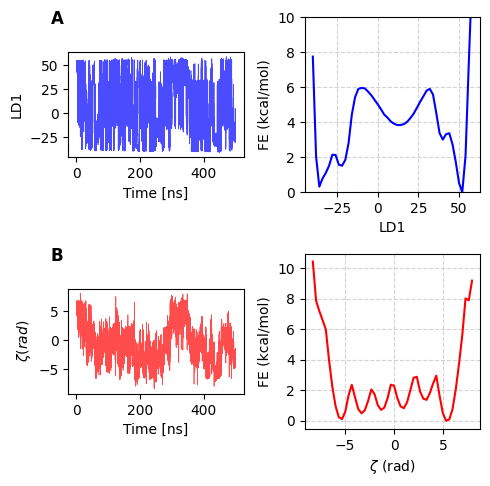

In [23]:
fig, axs =plt.subplots(2, 2, figsize=(5,5))
axs = axs.reshape([-1])

#0
axs[0].text(-0.1, 1.4, st.ascii_uppercase[0],transform=axs[0].transAxes, fontsize=12, fontweight='bold', va='top')
axs[0].set_box_aspect(0.6)
axs[0].set_yticks([-50,-25,0,25,50])
axs[0].set_xlabel('Time [ns]')
axs[0].set_ylabel('LD1')
axs[0].plot(t*1e-3, l, 'b-', lw=0.5, alpha=0.7)

#1
axs[1].set_box_aspect(1)
axs[1].set_ylim(0,10)
h,e = np.histogram(l, bins=50, density=True, weights=np.exp(b/kt))
g = (e[1:]+e[:-1])/2
f =-kt*np.log(h)
f -= f.min()

axs[1].grid(axis='both', which='major', linestyle='--', color='lightgrey')
axs[1].set_xlabel('LD1')
axs[1].set_ylabel('FE (kcal/mol)')
axs[1].set_xticks([-50,-25,0,25,50])
axs[1].plot(g, f, 'b-', lw=1.5)



#2
axs[2].text(-0.1, 1.4, st.ascii_uppercase[1], fontsize=12, fontweight='bold', va='top', transform=axs[2].transAxes)
axs[2].set_box_aspect(0.6)
axs[2].set_xlabel('Time [ns]')
axs[2].set_ylabel('$\zeta (rad)$')
axs[2].plot(t*1e-3, z, 'r-', lw=0.5, alpha=0.7)


#3
h,e = np.histogram(z, bins=50, density=True, weights=np.exp(b/kt))
g = (e[1:]+e[:-1])/2
f =-kt*np.log(h)
f -= f.min()

axs[3].grid(axis='both', which='major', linestyle='--', color='lightgrey')
axs[3].set_xlabel('$\zeta$ (rad)')
axs[3].set_ylabel('FE (kcal/mol)')
axs[3].plot(g, f, 'r-', lw=1.5)
axs[3].set_box_aspect(1)

fig.tight_layout()

plt.savefig('equal_wgts_summary_aib9.pdf', format='pdf')

In [24]:
print(kt)

0.794882


$ \textbf{ Load the pickled shapeGMM objects}$

In [15]:
sgmm_objs = []
for i in range(num_itr):
    with open('itr_%d/wsgmm.pickle'%(i+1), 'rb')as f:
        obj = pickle.load(f)
        sgmm_objs.append(obj)

In [16]:
num_atoms = 23

# store left helical states
prec_data_left = np.empty([num_itr, num_atoms, num_atoms])
mean_data_left  = np.empty([num_itr, num_atoms, 3])
cov_data_left = np.empty([num_itr, num_atoms, num_atoms])
corl_data_left = np.empty([num_itr, num_atoms, num_atoms])


# store right helical states
prec_data_right = np.empty([num_itr, num_atoms, num_atoms])
mean_data_right  = np.empty([num_itr, num_atoms, 3])
cov_data_right = np.empty([num_itr, num_atoms, num_atoms])
corl_data_right = np.empty([num_itr, num_atoms, num_atoms])

In [17]:
## To understand this numberings! please refer to the Bhattacharyya distance plot above.

# order is itr: 1 > 2 > 3 > 4. And form is : [left cluster# , right cluster#]
state_indx = [[0,1],[1,0], [2,0], [0,2]]   


for i in range(num_itr):
    so = sgmm_objs[i]
    
    # left
    prec_data_left[i] = so.precisions[state_indx[i][0]]
    mean_data_left[i] = so.centers[state_indx[i][0]]
    cov_data_left[i] = np.linalg.pinv(prec_data_left[i])
    
    # right 
    prec_data_right[i] = so.precisions[state_indx[i][1]]
    mean_data_right[i] = so.centers[state_indx[i][1]]
    cov_data_right[i] = np.linalg.pinv(prec_data_right[i])
    
    for j in range(num_atoms):
        for k in range(num_atoms):
            corl_data_left[i,j,k] = cov_data_left[i,j,k]/np.sqrt(cov_data_left[i,j,j]*cov_data_left[i,k,k])
            corl_data_right[i,j,k] = cov_data_right[i,j,k]/np.sqrt(cov_data_right[i,j,j]*cov_data_right[i,k,k])

### correlation matrcies for left helical states

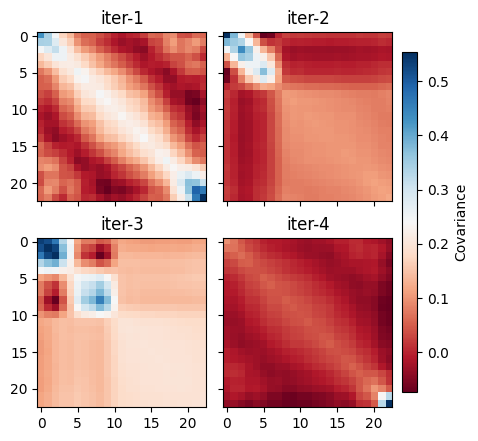

In [18]:
fig, axs = plt.subplots(2,2, figsize=(5,5), sharex=True, sharey=True)
axs = axs.reshape([-1])
axs[0].set_xticks(np.arange(0,25,5))
axs[0].set_yticks(np.arange(0,25,5))

for i in range(num_itr):
    axs[i].set_title('iter-%d'%(i+1))
    axs[i].set_box_aspect(1)
    im = axs[i].imshow(cov_data_left[i,:], cmap='RdBu')
    #im = axs[i].imshow(corl_data_left[i,:], cmap='RdBu', vmin=-1.0, vmax=1.0)

# Create a common colorbar
cbar_ax = fig.add_axes([0.81, 0.15, 0.03, 0.68])  # [x, y, width, height]
#cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(-1,1.2,0.2))  # use for corrl
cbar = fig.colorbar(im, cax=cbar_ax)

#cbar.set_ticklabels(np.arange(4))
#cbar.set_label('Correlation')
cbar.set_label('Covariance')
 
#fig.tight_layout()
fig.subplots_adjust(hspace=0.15, left=0.08, wspace=0.1, right=0.79)
#plt.savefig('corrl_left_states.pdf', format='pdf')
plt.savefig('covar_left_states.pdf', format='pdf')

### correlation matrices for right helical states

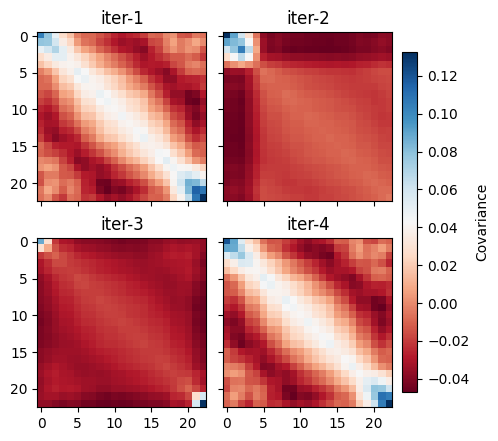

In [19]:
fig, axs = plt.subplots(2,2, figsize=(5,5), sharex=True, sharey=True)
axs = axs.reshape([-1])
axs[0].set_xticks(np.arange(0,25,5))
axs[0].set_yticks(np.arange(0,25,5))

for i in range(num_itr):
    axs[i].set_title('iter-%d'%(i+1))
    axs[i].set_box_aspect(1)
    im = axs[i].imshow(cov_data_right[i,:], cmap='RdBu')
    #im = axs[i].imshow(corl_data_right[i,:], cmap='RdBu', vmin=-1.0, vmax=1.0)

# Create a common colorbar
cbar_ax = fig.add_axes([0.81, 0.15, 0.03, 0.68])  # [x, y, width, height]
#cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(-1,1.2,0.2))  # use for corrl
cbar = fig.colorbar(im, cax=cbar_ax)

#cbar.set_ticklabels(np.arange(4))
#cbar.set_label('Correlation')
cbar.set_label('Covariance')
 
#fig.tight_layout()
fig.subplots_adjust(hspace=0.15, left=0.08, wspace=0.1, right=0.79)
#plt.savefig('corrl_right_states.pdf', format='pdf')
plt.savefig('covar_right_states.pdf', format='pdf')

### check rmsd for mean structures for L/R helices

In [21]:
print(mean_data_left.shape, mean_data_right.shape)

(4, 23, 3) (4, 23, 3)


In [22]:
from MDAnalysis.analysis.rms import rmsd 

rmsd_left = []
rmsd_right = []

for i in range(num_itr):
    
    l_xi = mean_data_left[i]
    r_xi = mean_data_right[i]
    
    for j in range(i+1, num_itr):
        l_xj = mean_data_left[j]
        r_xj = mean_data_right[j]
        
        l_val = rmsd(l_xj, l_xi, center=True, superposition=True)
        r_val = rmsd(r_xj, r_xi, center=True, superposition=True)
        
        rmsd_left.append(l_val)
        rmsd_right.append(r_val)

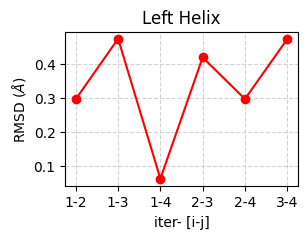

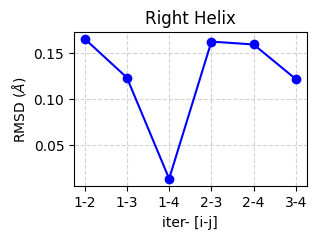

In [35]:
x_ax = ['1-2', '1-3', '1-4', '2-3', '2-4', '3-4']

plt.figure(figsize=(3,2))
plt.title('Left Helix')
plt.grid(axis='both', which='major', ls='--', color='lightgrey')
plt.xlabel('iter- [i-j]')
plt.ylabel('RMSD ($\\AA$)')
plt.plot(x_ax, rmsd_left, 'o-', color='r')

plt.figure(figsize=(3,2))
plt.title('Right Helix')
plt.grid(axis='both', which='major', ls='--', color='lightgrey')
plt.xlabel('iter- [i-j]')
plt.ylabel('RMSD ($\\AA$)')
plt.plot(x_ax, rmsd_right, 'o-', color='b')